# Sample code for trying out pytorch with this data

In [149]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import numpy as np
import pandas as pd
from src.data import make_dataset
from src.data import util

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
df = make_dataset.main(subsample=100, reduce_mem_usage=False)

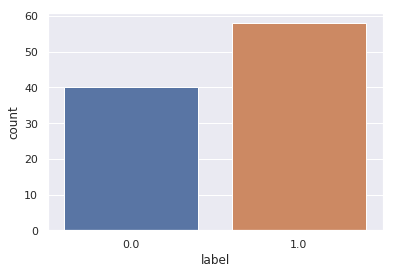

In [166]:
sns.countplot(df["label"])

## Convert data to pytorch types

In [192]:
data_vector = util.get_train_test(df)

In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train, x_test, y_train, y_test = util.transform_torch(data_vector, device=device)
print(x_train.shape, x_test.shape)

From numpy option does not send to device!


torch.Size([50, 1, 22050]) torch.Size([48, 1, 22050])


## Basic 1D convolutional network

[1D conv in Pytorch](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d) 

In the simplest case, the output value of the layer with input size

$$ (N, C_{\text{in}}, L) $$ and output $$ (N, C_{\text{out}}, L_{\text{out}}) $$ can be

$$ (N, C_{\text{in}}, L) $$ and output $$ (N, C_{\text{out}}, L_{\text{out}}) $$ can be
    precisely described as:

$$
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{in} - 1} \text{weight}(C_{\text{out}_j}, k)
        \star \text{input}(N_i, k)
$$ 

where $$ \star $$  is the valid "cross-correlation"  operator,
    N is a batch size, C denotes a number of channels,
    L is a length of signal sequence.

In [203]:
class BasicMosquitoNet(nn.Module):
    """A basic 1D conv net.
    We use 1D convolution, followed by max pool, 1D convolution, max pool, FC, FC.
    """
    
    def __init__(self, conv1_out=100, kernel_1=6, stride_1=3, 
                 conv2_out=10, kernel_2=4, stride_2=2):
        """
        conv1: (22050 - 6)/3  + 1 = 7349
        max_pool_1 = floor((Lin + −dilation×(kernel_size−1)−1)/stride_2) + 1
                   = floor(7349-2 /2) + 1 = 3673 + 1 = 3674
        conv2 = (3674 - 4)/2 + 1 = 1836
        max_pool_2 = floor(1836-2 /2) + 1 = 918
        
        """
        super(BasicMosquitoNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_out, 
                               kernel_size=kernel_1, stride=stride_1)
        self.conv2 = nn.Conv1d(in_channels=conv1_out, out_channels=conv2_out, 
                               kernel_size=kernel_2, stride=stride_2)
        self.fc1 = nn.Linear(918*conv2_out, 1)  
        #self.fc1 = nn.Linear(918*conv2_out, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. 
        """
        # Max pooling over a (2, 2) window
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        
        """
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        """
        # We use BCEWithLogitsLoss instead of applying sigmoid here
        # It is better computationally
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Try out some basic checks:

In [204]:
# Print Net structure
net = BasicMosquitoNet()
print(net)

BasicMosquitoNet(
  (conv1): Conv1d(1, 100, kernel_size=(6,), stride=(3,))
  (conv2): Conv1d(100, 10, kernel_size=(4,), stride=(2,))
  (fc1): Linear(in_features=9180, out_features=1, bias=True)
)


In [205]:
# Print params
net = BasicMosquitoNet()
params = list(net.parameters())
for param in params:
    print(param.size())  # conv1's .weight

torch.Size([100, 1, 6])
torch.Size([100])
torch.Size([10, 100, 4])
torch.Size([10])
torch.Size([1, 9180])
torch.Size([1])


In [207]:
# Check random example - remembering pytorch ONLY works in mini-batches
n_examples = 1000
temp_input = torch.randn(n_examples, 1, 22050).float()
out = net(temp_input)
print(out[:5])

tensor([[-0.0874],
        [-0.1451],
        [ 0.0205],
        [-0.1918],
        [-0.1852]], grad_fn=<SliceBackward>)


In [109]:
# Check loss function
# a dummy target, for example
target = torch.randint(2, (n_examples,)).float()
target = target.view(n_examples, -1)  # make it the same shape as output
criterion = nn.BCEWithLogitsLoss()

loss = criterion(out, target)
print(loss)

tensor(0.6968, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


We should see something ~ln(0.5) = ~0.693!!

In [110]:
# Check gradient 
net.zero_grad()
out.backward(torch.randn(n_examples, 1))

Check optimizer...

In [196]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(temp_input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Test with real data...

In [267]:
# create your optimizer
net = BasicMosquitoNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(x_train)
loss = criterion(output, y_train)
loss.backward()
optimizer.step()    # Does the update
print(loss)

tensor(33.0908, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [268]:
output = net(x_test)
loss = criterion(output, y_test)
print(loss)

tensor(1573344.3750, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
